# MobileNet

Use MobileNet to classify tomato ripeness (unripe, half-ripe, fully ripe)

In [2]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 1. Dataset

**Dataset**: tomatOD, [github](https://github.com/up2metric/tomatOD.git)

### 1.1 Load dataset

In [6]:
def load_annotations(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def crop_tomato(path, annotations, output, use_labels = True):
    for anno in annotations['annotations']:
        img_id = anno['image_id']
        img_in = next(item for item in annotations['images'] if item['id'] == img_id)
        img_pt = os.path.join(path, img_in['file_name'])
        image  = cv2.imread(img_pt)

        boundingbox = anno['bbox']
        x, y, w, h  = map(int, boundingbox)
        cropped = image[y:y+h, x:x+w]

        if w > 32 and h > 32:
            if use_labels and 'category_id' in anno:
                # Training case: use label to determine save directory
                label_id = anno['category_id']
                try:
                    label = next(item['name'] for item in annotations['categories'] if item['id'] == label_id)
                    save_path = os.path.join(output, label)
                except StopIteration:
                    print(f"Category ID {label_id} not found. Saving to 'unknown' directory.")
                    save_path = os.path.join(output, 'unknown')
            else:
                # Test case: save directly to test output directory
                save_path = output
            os.makedirs(save_path, exist_ok=True)
            filename = f"{img_in['file_name'].split('.')[0]}_{x}_{y}.jpg"
            #Resize: 224x224
            cropped_resized = cv2.resize(cropped, (224, 224))
            cv2.imwrite(os.path.join(save_path, filename), cropped_resized)

train_annotations = load_annotations('./data/tomatOD_annotations/tomatOD_train.json')
crop_tomato('./data/train', train_annotations, './data/preprocessed/train', use_labels = True)

test_annotations = load_annotations('./data/tomatOD_annotations/tomatOD_test.json')
crop_tomato('./data/test', test_annotations, './data/preprocessed/test', use_labels = False)

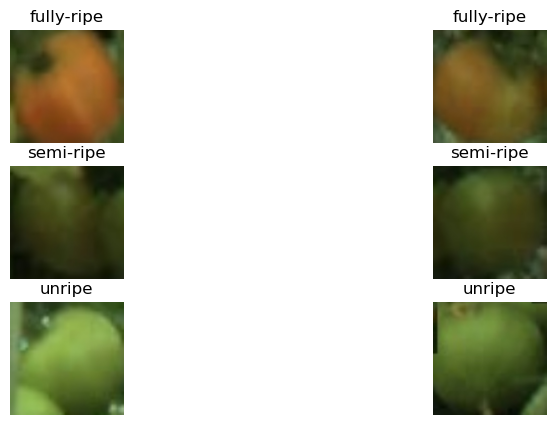

In [7]:
def visualize_cropped(output_dir, num_per_class=2):
    """Display cropped images per class."""
    classes = os.listdir(output_dir)
    plt.figure(figsize=(10, 5))
    for i, cls in enumerate(classes):
        img_files = os.listdir(os.path.join(output_dir, cls))[:num_per_class]
        for j, img_file in enumerate(img_files):
            img_path = os.path.join(output_dir, cls, img_file)
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            plt.subplot(len(classes), num_per_class, i*num_per_class + j + 1)
            plt.imshow(image)
            plt.title(cls)
            plt.axis('off')
    plt.show()

visualize_cropped('./data/preprocessed/train')

### 1.2 Split data

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Load training dataset
train_dataset = datasets.ImageFolder('./data/preprocessed/train', transform=transform)

#Split training dataset: train/validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [10]:
#Define a custom dataset class for test data without labels
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, -1  # Placeholder label since test data has no labels

#Load test dataset
test_dataset = TestDataset('./data/preprocessed/test', transform=transform)

In [11]:
#Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_dataset)}")

Train samples: 1547, Validation samples: 387, Test samples: 463


## 2. MobileNet Structure

### 2.1 DepthwiseSeparateConvolution Block

In [14]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, inplane, outplane, stride = 1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise  = nn.Conv2d(inplane, inplane, kernel_size = 3, stride = stride, padding = 1, groups = inplane)
        self.batchnorm1 = nn.BatchNorm2d(inplane)
        self.pointwise  = nn.Conv2d(inplane, outplane, kernel_size = 1)
        self.batchnorm2 = nn.BatchNorm2d(outplane)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.batchnorm1(out)
        out = F.relu(out)
        out = self.pointwise(out)
        out = self.batchnorm2(out)
        out = F.relu(out)
        return out

### 2.2 MobileNet

In [16]:
class MobileNetLikeCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetLikeCNN, self).__init__()
        self.layers = nn.Sequential(
            DepthwiseSeparableConv(3, 32, stride=1),    # Input: 3 channels (RGB)
            DepthwiseSeparableConv(32, 64, stride=2),   # Downsample
            DepthwiseSeparableConv(64, 128, stride=1),  #
            DepthwiseSeparableConv(128, 256, stride=2), # Downsample
            nn.AdaptiveAvgPool2d(1)                     # Reduce to 1x1
        )
        self.fc = nn.Linear(256, num_classes)           # Classification layer

    def forward(self, x):
        x = self.layers(x)         # Output: [batch_size, 256, 1, 1]
        x = x.view(-1, 256)        # Flatten to [batch_size, 256]
        x = self.fc(x)             # Output: [batch_size, num_classes]
        return x

In [17]:
#Usage
model = MobileNetLikeCNN(num_classes = 3)
print(model)

MobileNetLikeCNN(
  (layers): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
      (batchnorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
      (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (batchnorm1): BatchN

## 3. Training

In [19]:
#loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%')

Epoch 1, Loss: 0.661184090132616
Validation Accuracy: 73.90180878552971%
Epoch 2, Loss: 0.45730510962252713
Validation Accuracy: 80.87855297157623%
Epoch 3, Loss: 0.4057507001015605
Validation Accuracy: 84.23772609819122%
Epoch 4, Loss: 0.3879731051167663
Validation Accuracy: 87.08010335917312%
Epoch 5, Loss: 0.37743537067150584
Validation Accuracy: 85.78811369509044%


## 4. Test

In [21]:
model.eval()
predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4133916..1.2853642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34993464..1.1628151].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.1890757].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..0.7251401].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40222222..1.0402662].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36201733..1.7142857].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3

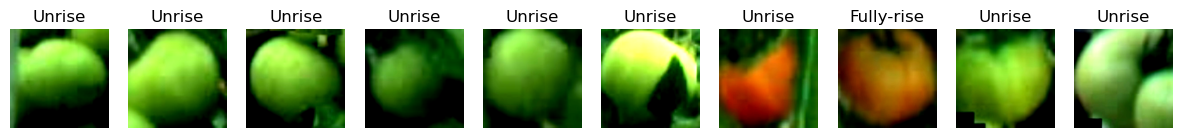

In [22]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

num_images_to_show = 10
plt.figure(figsize=(15, 5))
for i in range(min(num_images_to_show, len(test_dataset))):
    ax = plt.subplot(1, num_images_to_show, i + 1)
    image, _ = test_dataset[i]
    imshow(image)
    ax.set_title("Fully-rise" if predictions[i] == 0 else "Semi-rise" if predictions[i] == 1 else "Unrise")
plt.show()

****